## PATE Analysis on Deep Learning Models

PATE analysis is carried out on a system of deep learning in which many models after training themselves, are used to label unlabelled data. The unlabelled data provided by all the trained models (we'll call them teachers) are evaluated using differential privacy algorithmic frameworks like PATE to test for leakage of private data (using a term called epsilon).

In [0]:
import torch
import numpy as np
from torch import nn

Download the training and test data (MNIST dataset) using PyTorch like so..

In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST(root="./data", download=True, train=True, transform=transform)

# Download and load the test data
testset = datasets.MNIST(root="./data", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27583273.01it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 446226.02it/s]
  1%|          | 16384/1648877 [00:00<00:11, 142251.90it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6810117.20it/s]                           
8192it [00:00, 175192.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Splitting the training set into 10 more training sets

In [28]:
from torch.utils.data.sampler import SubsetRandomSampler

def split_train_set():
    train_len = len(trainset)
    indices = list(range(train_len))
    split = int(np.floor(0.1 * train_len))
    indice = []  #true indices to be fed to the PATE analysis algorithm
    for image,label in testloader:
      label = np.array(label)
      indice.append(label)
    indice = np.array(indice)
    indice = indice.flatten()
    print(indice.shape)
    trainloaders=[]
    for i in range(10):
        train_idx = indices[split:] #splitting training set into 10 equal parts, each a seperate teacher
        train_sampler = SubsetRandomSampler(train_idx)
        trainloader = torch.utils.data.DataLoader(trainset,batch_size=16,sampler=train_sampler)
        trainloaders.append(trainloader)
    
    return trainloaders,indice #return teacher models and the true indices

teachers,indice = split_train_set()
num_teachers = 10
num_examples = 10000  #10,000 unlabelled datapoints in the testset
num_labels = 10

(10000,)


Now the interesting part, training the model ;)

Training for teacher:1
Accuracy: 1.0
Loss:0.3345402730263908 epoch:1
Val_Loss:0.17772635987400537 epoch:1
Accuracy: 1.0
Loss:0.17759204841217163 epoch:2
Val_Loss:0.12533356979615595 epoch:2
Accuracy: 1.0
Loss:0.14153108568277847 epoch:3
Val_Loss:0.11610646435550255 epoch:3
Accuracy: 1.0
Loss:0.12356818680808 epoch:4
Val_Loss:0.10678529863156745 epoch:4
Accuracy: 1.0
Loss:0.11411991159218855 epoch:5
Val_Loss:0.10133758741226447 epoch:5
Accuracy: 1.0
Loss:0.10553381695159866 epoch:6
Val_Loss:0.09476541343305411 epoch:6
Accuracy: 1.0
Loss:0.09707936591157286 epoch:7
Val_Loss:0.09049195245066893 epoch:7
Accuracy: 1.0
Loss:0.09277822614732173 epoch:8
Val_Loss:0.08605789827825149 epoch:8
Accuracy: 1.0
Loss:0.09023889355356651 epoch:9
Val_Loss:0.10131225026702594 epoch:9
Accuracy: 1.0
Loss:0.08371517169616978 epoch:10
Val_Loss:0.0949283909372207 epoch:10
(10000,)
Training for teacher:2
Accuracy: 1.0
Loss:0.08144907515605883 epoch:1
Val_Loss:0.10300747982416132 epoch:1
Accuracy: 1.0
Loss:0.081

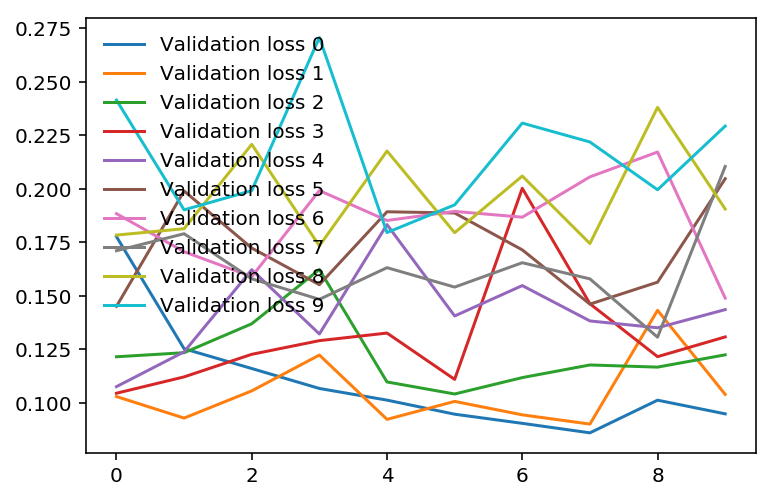

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #using the CUDA cores of Nvidia's Tesla K80
from torch import optim
model = nn.Sequential(nn.Dropout(p=0.2), #setting a dropout with a probability of 0.2 to counter overfitting
                     nn.Linear(784,512), #since the images are 28x28, we are giving a flattened input of 784 pixels
                     nn.ReLU(),
                     nn.Linear(512,256),
                     nn.ReLU(),
                     nn.Linear(256,10),
                     nn.LogSoftmax(dim=1)) #using a Log-Softmax activation for the output layer

criterion = nn.CrossEntropyLoss()  #calculating the cross entropy loss function
optimizer = optim.Adam(model.parameters(),lr=0.001) #using an Adam optimizer with a learning rate of 0.001

#Initialise 2 lists to later properly arrange the predictions made by all the teacher models
preds=[[],[],[],[],[],[],[],[],[],[]]
temp_preds = []
val_loss_all = [[],[],[],[],[],[],[],[],[],[]]


model.to(device) #move the model to the GPU

for i in range(num_teachers):
    run_loss,val_loss_gr = [],[]
    epochs = 10  #train each teacher model for 10 epochs
    print(f"Training for teacher:{i+1}")
    for e in range(epochs):
        running_loss = 0
        val_loss = 0
        for images, labels in teachers[i]:
            images = images.view(images.shape[0],-1)
            images, labels = images.to(device),labels.to(device)  #leveraging the computational power of Tesla K80
            output = model(images)
            optimizer.zero_grad()  #setting gradients to 0 before every epoch
            loss = criterion(output,labels)
            loss.backward() #our favourite back propagation
            optimizer.step()
            
            running_loss+=loss.item()
            
        else:
            with torch.no_grad(): #switch off gradient calculation for predictions
                model.eval() #disable dropout while making predictions
                temp = []  #list for storing predictions of all data points
                for image,label in testloader:
                    image = image.view(image.shape[0],-1)
                    image,label = image.to(device),label.to(device)
                    output = model(image)
                    loss = criterion(output,label)
                    ps = torch.exp(output) #finding the probablity distribution for an image
                    top_p,top_class = ps.topk(1,dim=1) #find the class that the model predicted
                    equals = top_class == label.view(*top_class.shape)
                    top_class = top_class.cpu()  #converting a GPU tensor to a normal CPU tensor for further processing
                    temp.append(top_class.flatten())
                    val_loss+=loss.item()
            print(f'Accuracy: {torch.sum(equals.type(torch.FloatTensor))}')
            print(f"Loss:{running_loss/len(teachers[i])} epoch:{e+1}")
            print(f"Val_Loss:{val_loss/len(testloader)} epoch:{e+1}")
            run_loss.append(running_loss/len(teachers[i]))
            val_loss_gr.append(val_loss/len(testloader))
        model.train() #re-enable dropout


    val_loss_all[i-1] = val_loss_gr  
    temp = np.array(temp)
    print(temp.shape)
    preds[i-1] = temp
    

preds = np.array(preds) #predictions made by all 10 teacher sets stored in this list

for d in range(10):
  plt.plot(val_loss_all[d-1], label=f'Validation loss {d}')
plt.legend(frameon=False)

            


Now that we have both the predictions from all the 10 teacher models and also the actual labels, we'll now do the PATE analysis on 2 scenarios

1. Without adding any noise in the predicted labels and applying PATE analysis

In [70]:
#!pip install syft  #installing the PySyft framework which has the PATE analysis API
from syft.frameworks.torch.differential_privacy import pate


for i in range(10):
  equals = indice == preds[i-1]
  print(f'Accuracy given by teacher {i+1}: {np.mean(equals)*100}%')


data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indice, noise_eps=0.1, delta=1e-5) #calculating the epsilon scores using PATE Analysis
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Accuracy given by teacher 1: 97.57000000000001%
Accuracy given by teacher 2: 97.82%
Accuracy given by teacher 3: 97.61%
Accuracy given by teacher 4: 97.94%
Accuracy given by teacher 5: 97.7%
Accuracy given by teacher 6: 97.54%
Accuracy given by teacher 7: 97.92999999999999%
Accuracy given by teacher 8: 97.8%
Accuracy given by teacher 9: 97.87%
Accuracy given by teacher 10: 97.72999999999999%
Data Independent Epsilon: 411.5129254649703
Data Dependent Epsilon: 411.51292546502725


2. After adding  noise in the predicted labels and applying PATE analysis.

We will be adding Laplacian noise to the predicted labels. Now, if predictions were near perfect, we should get the same epsilon scores even after noise is added to the predictions

In [71]:
for i in range(10):
  beta = 1/0.1  #adding the beta parameter to adding Laplacian noise
  preds[i-1] = preds[i-1]+np.random.laplace(0,beta,1)  #Add noise as per a Laplacian distribution from 0 to 1 centered at beta

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indice, noise_eps=0.1, delta=1e-5) #calculating the epsilon scores using PATE Analysis
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 411.5129254649703
Data Dependent Epsilon: 411.51292546502725


As we see, there is no difference in epsilon scores even after adding **randomized** Laplacian noise to the predicted labels.

This implies that the differential privacy analysis vis PATE on the dataset was done as per Cynthia Dwork's algorithmic definition of differential privacy